<h1>Brain MRI Images for Brain Tumor Detection</h1>

importing the libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from matplotlib.image import imread

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/brain tumor.zip')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
os.listdir('/tmp/brain_tumor_dataset')

['no', 'yes']

In [5]:
len(os.listdir('/tmp/brain_tumor_dataset/yes/'))

155

In [7]:
len(os.listdir('/tmp/brain_tumor_dataset/no/'))

98

In [8]:
root_dir = '/tmp/brain_tumor_dataset'
number_of_images = {}

for dir in os.listdir(root_dir):
  number_of_images[dir] = len(os.listdir(os.path.join(root_dir,dir)))

In [8]:
number_of_images

{'no': 98, 'yes': 155}

we shall split the dataset into:
* 70% training data
* 15% testing data
* 15% validation data

In [9]:
import math
import shutil

creating the folder - train, test, val

In [10]:
def datafolder(path,split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)     # root --> train

    for dir in os.listdir(root_dir):
      os.makedirs("./"+path+"/"+dir)   # root --> train --> yes/no
      for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)),
                                  size=(math.floor(split*number_of_images[dir])),
                                  replace=False):
        O = os.path.join(root_dir, dir, img)    # origin
        D = os.path.join("./"+path,dir)         # destination  root -->train---> yes ---> imagefile
        shutil.copy(O,D)
        os.remove(O)
  else:
    print("Path already exists")

In [11]:
datafolder('train',0.7)

In [12]:
train_n_img = {}
for dir in os.listdir("./train/"):
  train_n_img[dir] = len(os.listdir(os.path.join("./train/",dir)))

In [13]:
train_n_img

{'no': 68, 'yes': 108}

In [27]:
datafolder('test',0.15)

In [12]:
datafolder('val',0.15)

Text(0.5, 1.0, 'A Brain Tumor MRI Image')

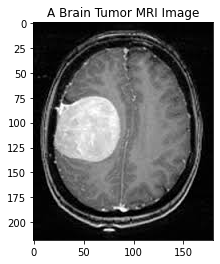

In [13]:
os.listdir('train'+'/yes')[0]
plt.imshow(imread('train'+'/yes/Y1.jpg'))
plt.title("A Brain Tumor MRI Image")

Text(0.5, 1.0, 'A Normal MRI Image without brain tumor')

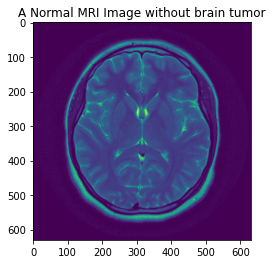

In [14]:
os.listdir('train'+'/no')[0]
plt.imshow(imread('train'+'/no/1 no.jpeg'))
plt.title("A Normal MRI Image without brain tumor")

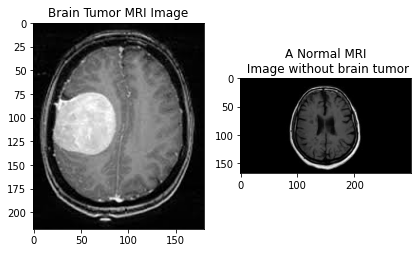

In [16]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(imread('train'+'/yes/Y1.jpg'))
axes[0].title.set_text('Brain Tumor MRI Image')

axes[1].imshow(imread('train'+'/no/11 no.jpg'))
axes[1].title.set_text('A Normal MRI\n Image without brain tumor')

plt.tight_layout()
plt.autoscale(enable=True, axis='both')

In [17]:
imread('train'+'/yes/Y1.jpg').shape

(218, 180, 3)

# Building CNN model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [19]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

Data pre-processing

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
def preprocessing(path):
  image_data = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   zoom_range=0.2,
                                   rescale=1/255,
                                   shear_range=0.2,
                                   horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         batch_size=16, class_mode='binary')
  return image

In [24]:
train_data = preprocessing('/content/train')

Found 176 images belonging to 2 classes.


In [25]:
def preprocessing2(path):
  image_data = ImageDataGenerator(rescale=1/255)
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         batch_size=16, class_mode='binary',
                                         shuffle=False)
  return image

In [28]:
test_data = preprocessing2('/content/test')
val_data = preprocessing2('/content/val')

Found 37 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(monitor='val_loss', filepath='./bestmodel.h5',save_best_only=True, mode='auto')

cb = [early_stop,mc]

In [30]:
model.fit(train_data, epochs=50, validation_data=val_data,callbacks=cb)

Epoch 1/50
11/11 [==============================] - 14s 186ms/step - loss: 0.8588 - accuracy: 0.6364 - val_loss: 0.5923 - val_accuracy: 0.6216
Epoch 2/50
11/11 [==============================] - 2s 173ms/step - loss: 0.6256 - accuracy: 0.6364 - val_loss: 0.5369 - val_accuracy: 0.7838
Epoch 3/50
11/11 [==============================] - 2s 163ms/step - loss: 0.5830 - accuracy: 0.7273 - val_loss: 0.4502 - val_accuracy: 0.7838
Epoch 4/50
11/11 [==============================] - 2s 165ms/step - loss: 0.5591 - accuracy: 0.7330 - val_loss: 0.4298 - val_accuracy: 0.8108
Epoch 5/50
11/11 [==============================] - 2s 163ms/step - loss: 0.5795 - accuracy: 0.6932 - val_loss: 0.4817 - val_accuracy: 0.7568
Epoch 6/50
11/11 [==============================] - 2s 157ms/step - loss: 0.5249 - accuracy: 0.7500 - val_loss: 0.4436 - val_accuracy: 0.7838
Epoch 7/50
11/11 [==============================] - 2s 155ms/step - loss: 0.4765 - accuracy: 0.7557 - val_loss: 0.5901 - val_accuracy: 0.6757
Epoch

In [31]:
df = pd.DataFrame(model.history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.858751,0.636364,0.592322,0.621622
1,0.625599,0.636364,0.536896,0.783784
2,0.583039,0.727273,0.450206,0.783784
3,0.559138,0.732955,0.429759,0.810811
4,0.579545,0.693182,0.481665,0.756757
5,0.524920,0.750000,0.443613,0.783784
6,0.476526,0.755682,0.590077,0.675676
7,0.507018,0.767045,0.429682,0.783784
8,0.509310,0.750000,0.433856,0.783784
9,0.511023,0.755682,0.508485,0.729730


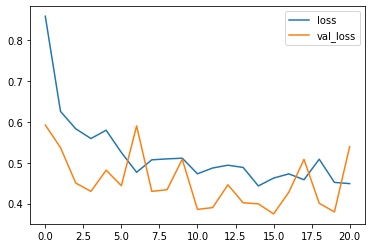

In [32]:
df[['loss','val_loss']].plot()

In [33]:
from tensorflow.keras.models import load_model
best_model = load_model("./bestmodel.h5")

Model Evaluation

In [34]:
acc = best_model.evaluate(test_data)
print("The accuracy of our model: ",acc[1]*100,"%")

3/3 [==============================] - 0s 48ms/step - loss: 0.5504 - accuracy: 0.7568
The accuracy of our model:  75.67567825317383 %


In [36]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/test/yes/Y10.jpg', target_size=(150,150))
img_arr = image.img_to_array(img)/255
img_arr = np.expand_dims(img_arr, axis=0)

Text(0.5, 1.0, 'to be predicted')

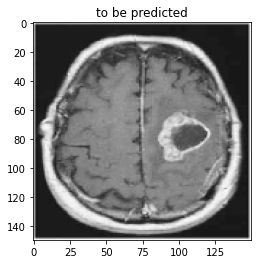

In [37]:
plt.imshow(img_arr.reshape(150,150,3))
plt.title("to be predicted")

In [38]:
pred = best_model.predict(img_arr)
pred_classes = (pred > 0.5).astype("int32")
pred_classes

array([[1]], dtype=int32)

In [39]:
if pred_classes == 0:
  print("The image is not having a tumor")
elif pred_classes == 1:
  print("The image is having a tumor")
else:
  print("Not known!!!")

The image is having a tumor


In [40]:
test_data.class_indices

{'no': 0, 'yes': 1}

In [41]:
pred_total = best_model.predict(test_data)
pred_classes_total = (pred_total > 0.5).astype("int32")

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.classes, pred_classes_total))
print(confusion_matrix(test_data.classes, pred_classes_total))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.79      0.83      0.81        23

    accuracy                           0.76        37
   macro avg       0.74      0.73      0.74        37
weighted avg       0.75      0.76      0.75        37

[[ 9  5]
 [ 4 19]]


We have achieved 76% accuracy

# Transfer Learning using MobileNet

In [43]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

Data pre-processing

In [44]:
def preprocessing(path):
  image_data = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   zoom_range=0.2,
                                   preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         batch_size=16, class_mode='binary')
  return image

In [45]:
train_data = preprocessing('/content/train')

Found 176 images belonging to 2 classes.


In [46]:
def preprocessing2(path):
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input)  # preprocess_input is from the same pre-processing steps taking place from MObilNet Architecture
  image = image_data.flow_from_directory(directory=path, target_size=(150,150),
                                         batch_size=16, class_mode='binary',
                                         shuffle=False)
  return image

In [47]:
test_data = preprocessing2('/content/test')
val_data = preprocessing2('/content/val')

Found 37 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [48]:
base_model = MobileNet(input_shape=(150,150,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [49]:
# to make sure we won't re-train the model again
for layer in base_model.layers:
  layer.trainable = False

In [50]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [51]:
# club the pre-trained model with our custom model
X =Flatten()(base_model.output)  # last layer in base_model
X = Dense(units=1, activation='sigmoid')(X)

In [52]:
tf_model = Model(base_model.input, X)

In [53]:
tf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                      

In [54]:
tf_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(monitor='val_loss', filepath='./bestmodel2.h5',save_best_only=True, mode='auto')

cb = [early_stop,mc]

Training the model

In [56]:
result_tf = tf_model.fit(train_data, 
                          steps_per_epoch=8,
                         epochs=30, 
                         validation_data=val_data, 
                         callbacks=cb)

Epoch 1/30
8/8 [==============================] - 5s 341ms/step - loss: 3.6391 - accuracy: 0.5547 - val_loss: 0.2529 - val_accuracy: 0.8919
Epoch 2/30
8/8 [==============================] - 1s 184ms/step - loss: 0.5020 - accuracy: 0.9062 - val_loss: 0.3607 - val_accuracy: 0.8649
Epoch 3/30
8/8 [==============================] - 1s 183ms/step - loss: 0.7819 - accuracy: 0.7969 - val_loss: 0.6210 - val_accuracy: 0.8378
Epoch 4/30
8/8 [==============================] - 2s 214ms/step - loss: 0.8252 - accuracy: 0.8047 - val_loss: 0.0643 - val_accuracy: 1.0000
Epoch 5/30
8/8 [==============================] - 1s 184ms/step - loss: 0.4324 - accuracy: 0.9141 - val_loss: 3.2197 - val_accuracy: 0.5135
Epoch 6/30
8/8 [==============================] - 1s 184ms/step - loss: 0.7002 - accuracy: 0.8594 - val_loss: 0.0832 - val_accuracy: 0.9459
Epoch 7/30
8/8 [==============================] - 1s 184ms/step - loss: 0.3204 - accuracy: 0.9219 - val_loss: 0.8092 - val_accuracy: 0.8378
Epoch 8/30
8/8 [====

In [57]:
best_model_2 = load_model('/content/bestmodel2.h5')

In [58]:
result_df = pd.DataFrame(tf_model.history.history)
result_df

,loss,accuracy,val_loss,val_accuracy
0,3.639111,0.554688,0.252893,0.891892
1,0.502042,0.906250,0.360665,0.864865
2,0.781868,0.796875,0.621027,0.837838
3,0.825236,0.804688,0.064265,1.000000
4,0.432395,0.914062,3.219737,0.513514
5,0.700153,0.859375,0.083221,0.945946
6,0.320386,0.921875,0.809218,0.837838
7,0.435511,0.867188,0.042800,1.000000
8,0.163516,0.945312,0.778820,0.837838
9,0.143357,0.968750,0.621828,0.837838


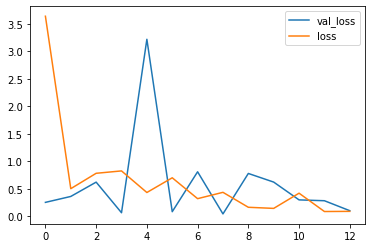

In [59]:
result_df[['val_loss','loss']].plot()

Model Evaluation

In [60]:
acc = tf_model.evaluate(test_data)[1]
print("The accuracy of our model: ",acc*100,"%")

3/3 [==============================] - 0s 48ms/step - loss: 1.2961 - accuracy: 0.8378
The accuracy of our model:  83.7837815284729 %


In [62]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/test/yes/Y10.jpg', target_size=(150,150))
img_arr = image.img_to_array(img)/255
img_arr = np.expand_dims(img_arr, axis=0)

Text(0.5, 1.0, 'to be predicted')

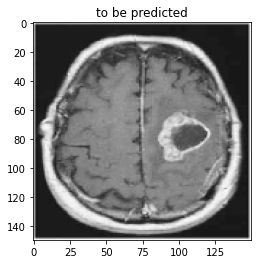

In [63]:
plt.imshow(img_arr.reshape(150,150,3))
plt.title("to be predicted")

In [64]:
pred = best_model_2.predict(img_arr)
pred_classes = (pred > 0.5).astype("int32")
pred_classes

array([[1]], dtype=int32)

In [65]:
if pred_classes == 0:
  print("The image is not having a tumor")
elif pred_classes == 1:
  print("The image is having a tumor")
else:
  print("Not known!!!")

The image is having a tumor


In [66]:
pred_total = best_model_2.predict(test_data)
pred_classes_total = (pred_total > 0.5).astype("int32")

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.classes, pred_classes_total))
print(confusion_matrix(test_data.classes, pred_classes_total))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.87      0.87      0.87        23

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37

[[11  3]
 [ 3 20]]


We achieved 84% accuracy using transfer leaning technique